In [1]:
import pyaudio
import wave
import numpy as np
import matplotlib.pyplot as plt
import seaborn; seaborn.set_style('whitegrid')
import time
from pdb import set_trace
from scipy import signal
import librosa as lbr
import librosa.display

In [27]:
FORMAT = pyaudio.paInt16
CHANNELS = 1
Fs = 8000
CHUNK = 1024
REC_TIME = 15 #sec
audio = pyaudio.PyAudio()
# start Recording
stream = audio.open(format=FORMAT, channels=CHANNELS,
                rate=Fs, input=True,
                frames_per_buffer=CHUNK)
i=0
data = stream.read(CHUNK)  
data_int = decoded = np.frombuffer(data, np.int16);
voice=data_int
idx=0
acc=0
while True:
    idx+=1
    
    start=time.time()
    data = stream.read(CHUNK)  
    acc+=time.time()-start
    decoded = np.frombuffer(data, np.int16);
    voice=np.concatenate((voice,decoded))
    i+=1
    if(i == int(REC_TIME*Fs/CHUNK)):
        break
        
voice = voice[int(0.5*Fs):-1]
print('avg read time/chunk: ',acc/idx)
N=voice.shape[0]

avg read time/chunk:  0.12844895297645503


In [4]:
from scipy.ndimage import grey_dilation
from scipy.ndimage import grey_closing
from scipy.ndimage import grey_erosion
from scipy.ndimage import grey_opening

/home/markos/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]


Text(0.5, 1.0, 'Signal with respect to filtered entropy')

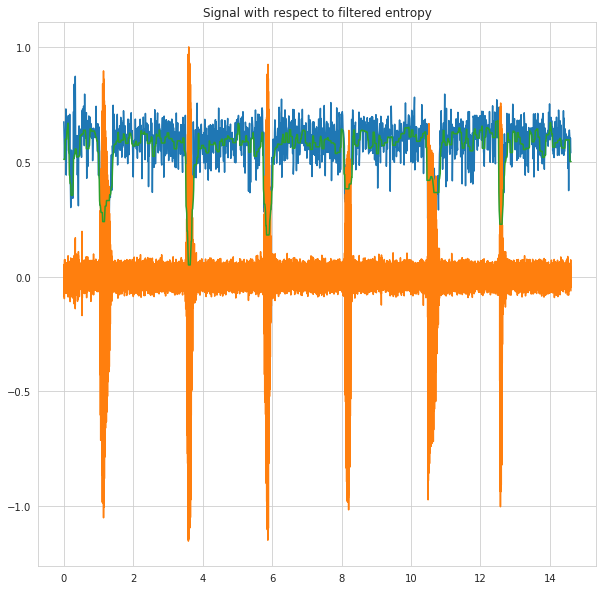

In [36]:
S_WIND = int(0.01 * Fs)
N_FFT=2048
K=1
%matplotlib inline

#STFT
f,t,stft=signal.stft(voice,fs=Fs,nperseg=S_WIND,noverlap=0,return_onesided=True)
#Power spectrum probability
S=np.abs(stft)**2 #Energy
#filter energies not needed
# S[np.logical_and(f<300,f>3000)] = 0

P=np.divide(S,np.sum(S,axis=0))
#Power spectrym entropy
H=-np.multiply(P,np.log2(P)).sum(axis=0)/np.log2(P.shape[0])

#Help distinguish with energy
E = S.sum(axis=0)
H = np.multiply(H,1-E/E.max())
H_size = H.shape[0]



Hf = H
# Hf = signal.order_filter(Hf,domain=np.ones(9),rank=0)
# Hf=grey_opening(Hf,size=(3))
Hf = signal.medfilt(Hf,kernel_size=7)
Hf = grey_erosion(Hf,size=(6))

plt.figure(figsize=(10,10))
plt.plot(t,H)
plt.plot(np.array(range(N))/Fs,voice/voice.max())
plt.plot(t,Hf)
plt.title('Signal with respect to filtered entropy')
